## Transporation mode choice modeling

Transportation planning and assessments are important aspects of modeling urban systems and are critical in making key decisions and shaping/estimating the commute behavior of urban populace. Some of the key impact assessments from the model could be evaluating change in net commute time savings, change in pollution emissions, traffic volumes etc. across an urban area of interest.

Here we demonstrate a framework for transporation mode choice modeling using Bayesian inference. Essentially, we want to model ridership by mode across multiple modes by estimating mode choice between origin-destination taxi zone pairs in New York City among 4 available mode choices - transit, taxi, walking and driving. 

We shall use the model to assess the projected impact of transportation interventions, e.g. imposing a $3 congestion surcharge on the taxies accross NYC (similar to the Manhattan Congestion Surcharge actually implemented but now accross the entire city).

This case comes from our project with NYU C2SMART supported by US DOT on assessing the impact of ride-sharing in NYC. You may find a complete presentation here: https://www.youtube.com/watch?v=5L5r5nvsudI
and a publication on https://arxiv.org/abs/2010.06588

In [ ]:
# !pip install arviz==0.11.4
# !pip install pymc3==3.11.4
# !pip install Theano==1.0.4

# !pip install arviz==0.11.0
# !pip install pymc3==3.10.0
# !pip install Theano-PyMC

     |████████████████████████████████| 1.5 MB 1.3 MB/s 
  Attempting uninstall: arviz
    Found existing installation: arviz 0.11.4
    Uninstalling arviz-0.11.4:
      Successfully uninstalled arviz-0.11.4


     |████████████████████████████████| 1.9 MB 4.2 MB/s 
     |████████████████████████████████| 2.8 MB 21.5 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.0.11-py3-none-any.whl size=2572038 sha256=22be51df20e39b6906bc59e70da4b3d1e2f2540caa311b4bfc3c23de81ece16c
  Stored in directory: /root/.cache/pip/wheels/45/cd/5b/6b7f84f36d564107f0786ce959bcb7641e07c764cb9abdf222
Successfully built theano-pymc
  Attempting uninstall: theano-pymc
    Found existing installation: Theano-PyMC 1.1.2
    Uninstalling Theano-PyMC-1.1.2:
      Successfully uninstalled Theano-PyMC-1.1.2
  Attempting uninstall: pymc3
    Found existing installation: pymc3 3.11.4
    Uninstalling pymc3-3.11.4:
      Successfully uninstalled pymc3-3.11.4


In [ ]:
import pandas as pd
import numpy as np
from numpy import inf
import seaborn as sns
from scipy.stats import norm
import itertools
import theano
from theano import tensor as tt
import pymc3 as pm
import arviz
from matplotlib import pyplot as plt
%matplotlib inline

We use data from primarily two sources: 
- the travel duration and fare cost for taxi, transit and driving modes are extracted from Google Maps API for each of the origin-destination taxi zone pairs. Cost for walking is kept as 0.
- the mobility information and aggregated income information is retrieved from LEHD data along with ACS for origin-destination commute choice information, further aggregated on taxi zone levels.


The combined data thus contains travel time, travel cost and aggregated commuter information corresponding to each of O-D pairs and 4 travel modes.

The travel modes (column 'tmode') contains codes for each mode referenced as- 2: transit, 3: taxi, 5: walking, 8: driving


In [ ]:
# read the data

# data = pd.read_csv('https://raw.githubusercontent.com/CUSP2022ADS/Labs/main/LEHD_commute.csv?token=GHSAT0AAAAAABQXLR7TSWPXJG3GPXXF52H4YSFXYPA')
data = pd.read_csv('LEHD_commute.csv')
data['duration'] = data['duration']/60  # convert time to hours
data['ridership'] = data.iloc[:, 5:].sum(axis=1)  ## aggregate the ridership across income groups
data = data[['pulocationid', 'dolocationid', 'tmode', 'duration', 'price', 'ridership']]
data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,12.721600,736
1,3,7,3,0.798016,43.157143,0
2,3,18,3,0.254000,12.900000,1748
3,3,18,5,1.084444,0.000000,3174
4,3,18,8,0.268923,7.432000,10879


In [ ]:
data.ridership.sum()

191552556

In [ ]:
# number of unique O-D pairs

len(data[['pulocationid', 'dolocationid']].drop_duplicates())

19152

In [ ]:
# unique modes

data.tmode.unique()

array([8, 3, 5, 2])

([<matplotlib.axis.XTick at 0x7fd7d0d31ed0>,
 [Text(0, 0, 'Transit'),
  Text(0, 0, 'Taxi'),
  Text(0, 0, 'Walking'),
  Text(0, 0, 'Driving')])

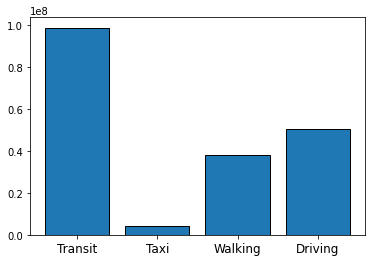

In [ ]:
## ridership by mode
byMode = data.groupby(by='tmode', as_index=False).sum()[['tmode', 'ridership']]
plt.bar(np.arange(len(byMode)), list(byMode.ridership), edgecolor = 'black')
plt.xticks([r  for r in range(len(byMode))], ['Transit', 'Taxi',
                                                      'Walking', 'Driving'], fontsize=12)

We use the Multinomial Logit (MNL) as the modeling framework for estimating the mode choice probabilities. MNL is broadly used in transportation choice modeling. It offers an advantage of estimating the mode-choice probabilities using closed-form formulas representing the aggregate-level choices.

the probabilities for each of the four major transportation modes to be chosen as having the highest utility is defined as
$$
\begin{equation}
    P_{mode} = \frac{e^{\lambda U_{mode}}}{e^{\lambda U_{taxi}} + e^{\lambda U_{transit}} + e^{\lambda U_{walk}} + e^{\lambda U_{drive}}}
\end{equation}
$$

$\lambda$ being subject to fit, which controls the sensitivity of the resulting mode choices to the differences in utility (the higher is lambda, the higher are the chances to choose the mode with the highest objective utility). We shall explain the idea of where the formulae comes from below.

Additionally, we define the utilily below.

Mathematically, the utility score $U_j$ for alternative ${j}$ depends on the time taken $T_j$ between the O-D pair in consideration and the monetary cost $P_j$ for choosing the alternative, and a random component of error $\epsilon_j$ , yielding a base utility function
$$
\begin{equation}
    U_j = -(CT_j + P_j)
\end{equation}$$

where C is kept as a constant. 

This objective utility can be interpreted as perceived total 'value' of a given mode for commuting between an o-d pair by the commuter, incorporating the direct cost and the cost of time. But if people were to make their choices excusively based on the objective utility we would have everyone choosing the same mode with the highest utility all the time. 

However the people may have some personal preferences for the certain modes to combine with the direct monetary cost to assess the overall subjective utility. The formulae of the multinomial logit model (MNL) choice probaiblities actually assesses the ratio of people for whom the given mode would have the highest subjective utility. In order to account for it an additional random error term $\epsilon$ following a particular distribution could be added to the objective utility. This way the subjective utility to be maximized is expressed as
$\begin{equation}
    U_j = -(CT_j + P_j) + \epsilon
\end{equation}$
and the formulae of the MNL model calculates the probability of having this subjective utility for any given mode the highest among all the available modes in the assumption than $\epsilon$ follows Weibull distribution.

See https://en.wikibooks.org/wiki/Fundamentals_of_Transportation/Choice_Modeling#The_Logit_Model for further details.


#### Likelihood estimation

From the estimated probabilities $P_m$, we compute the likelihood of the observed C2SMART data give the model for each set of $\beta, \sigma$ parameters. For mode choice probabilities $P_m(o,d,\sigma,\beta)$ for each set of origin(o) and destination(d), the log-likelihood for four modes given the observed C2SMART ridership $R_m(o,d)$ is calculated as
$$
\begin{equation}
    L(\sigma, \beta) = \sum_{o,d}\sum_m R_m(o,d)\ln P_m(o,d,\sigma,\beta)
\end{equation}
$$


One can simulate the results just for the max-likelihood parameters, however comprehensive parameter sampling provides assessment with respect to the model uncertainty.



In [ ]:
# choice for constant C - put as median hourly NYC income
# NYC median income is ~ $33,220 per year
# we count the total hours rather than business hours to get a somewhat lower bound estimate as people tend to undervalue the price of the time spend outside of work
# ideally C could be another parameter of the model, but here we go with a fixed estimate

C = 33220/(12*30*24)
C

3.8449074074074074

As defined in the utility function, the coefficient C can be interpreted as a parameter incorporating irrationality of decisions based on time and cost. 

We use the total number of hours in a day instead of number of working hours to assess the cost of time as people often underestimate the value of time.  So we try a lower bound value (which apparently also provides a better fit to the data). It could be a good idea to fit C as another parameter of the model, but we keep it fixed to make fitting easier for the illustration purposes.

Modeling:  We'll use Bayesian inference for fitting the model. There is just one parameter $\lambda$ in our model specifications. We will estimate it's posterior distribution from MCMC sampling.

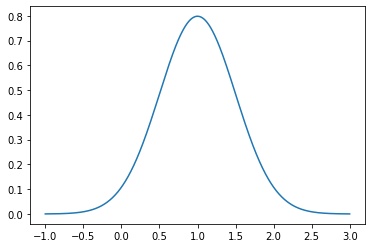

In [ ]:
# prior for lambda 

fig, ax = plt.subplots()
x= np.arange(-1,3,0.001)
ax.plot(x, norm.pdf(x, loc=1, scale=0.5))

plt.show()

In [ ]:
def MNL(lambda_, data):  # multinomial logit probabilities

    # compute probabilities from utility defined above
    prob_n = np.exp(lambda_*(-(np.random.normal(loc=data['duration'].values, scale=np.sqrt(data['duration'].values))*3.84 + 
                               np.random.normal(loc=data['price'].values, scale=np.sqrt(data['price'].values))) + np.random.normal(loc=0, scale=10)))
    prob_d = np.sum(prob_n)
    pred =  prob_n/prob_d
    return pred
    
def like(lambda_, obs=data['ridership'], return_prob=False):   # compute likelihood

    pred = []
    # scale = 10000**2

    # get MNL probabilities for each o-d travel modes
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
      data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):   # iterate each o-d
        odLoc = data[(data.pulocationid == o) & (data.dolocationid == d)]
        pred.append(MNL(lambda_, odLoc))

    pred = np.array(list(itertools.chain(*pred)))

    pred = pred.astype(float)
    pred[pred == 0] = 0.0001

    # return_prob argument is for getting numpy array vs tensor (required for MCMC sampling)
    if return_prob == True:
        return np.sum(np.log(pred)*obs)
    else:
        return tt.sum(tt.log(pred)*obs)

Let's estimate the posterior distribution of lambda parameter from MCMC simulations.

In [ ]:
with pm.Model() as transport_model:
    lambda1 = pm.Normal('lambda', mu=1, sd=0.5) # lambda prior

    likelihood = pm.Potential('likelihood', like(lambda1.random(), data['ridership'])) ## likelihood, we call above likelihood function with 'Potential' in pymc3
    start = pm.find_MAP()  # find max likelihood
    trace = pm.sample(1000, start=start, progressbar=True) # estimate posterior from MCMC sampling

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<Figure size 720x720 with 0 Axes>

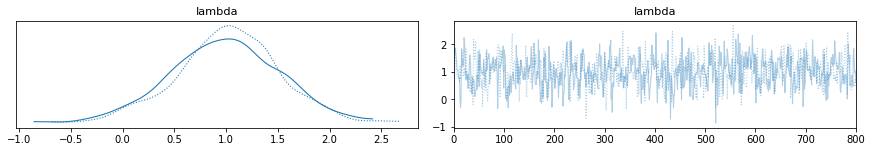

<Figure size 720x720 with 0 Axes>

In [ ]:
fig = arviz.plot_trace(trace[199:1000])
plt.figure(figsize = (10, 10))

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


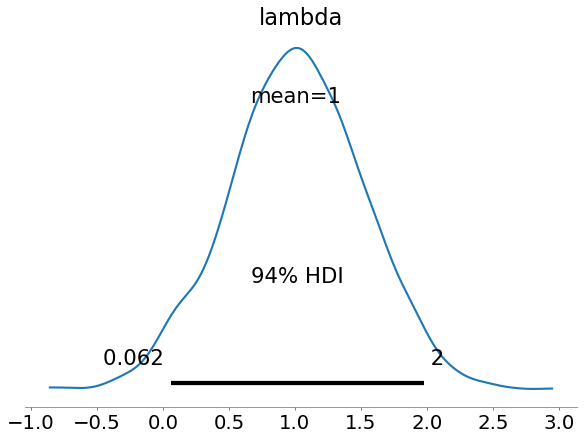

In [ ]:
arviz.plot_posterior(trace, figsize = (8, 6));

In [ ]:
# print max-likelihood lambda

print(start['lambda'])

1.0


### Assessing mode-shift in an intervention scenario

Now let's use the above model to evaluate the change in mobility across 4 modes when we impose an intervention case - additional surcharge of $3 for taxi rides anywhere in the city. One can expect a decrease in ridership for taxis owing to this intervention but assessing the mode-shift would enable to see how exactly the trips would redistribute across the other modes.

We will estimate the mode-shift numbers with respect to uncertainty by calculating the variance in trip numbers across all modes. This can be done by estimating variance of mode-shift numbers for lambdas drawn from posterior distribution, weighted by their likelihood values.

Now let's make another copy of data with the additional $3 surcharge to the taxi trips.

In [ ]:
data1 = data.copy()  # make new df
data1.loc[data1.tmode == 3, 'price'] = data1.loc[data1.tmode == 3, 'price'] + 3
data1.head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,12.721600,736
1,3,7,3,0.798016,46.157143,0
2,3,18,3,0.254000,15.900000,1748
3,3,18,5,1.084444,0.000000,3174
4,3,18,8,0.268923,7.432000,10879


Let's run the model and estimate aggregate mode-shift across modes w.r.t. uncertainty.

In [ ]:
lambdas = np.random.choice(trace['lambda'], 10)  # draw samples from lambda posterior
# this step could take ~15 mins for 100 samples, reduce the number of samples for faster

likes = []   # likelihood values
mobDiff = {2:[], 3:[], 5:[], 8:[]}   # mode-shift numbers

# estimate trips for lambdas and corresponding likelihoods
for l in lambdas:
    tempMob_noInter = {2:0, 3:0, 5:0, 8:0}   
    tempMob_Inter = {2:0, 3:0, 5:0, 8:0}
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
        data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):
    
        odLoc_noInter = data[(data.pulocationid == o) & (data.dolocationid == d)]
        odLoc_Inter = data1[(data1.pulocationid == o) & (data1.dolocationid == d)]  
        modes = odLoc_Inter.tmode.values

        # probabilities for pre-intervention and post-intervention
        prob_noInter = MNL(l, odLoc_noInter)  
        prob_Inter = MNL(l, odLoc_Inter)    

        for index, mode in enumerate(modes):
            tempMob_Inter[mode] = tempMob_Inter[mode] + prob_Inter[index]*np.sum(odLoc_noInter['ridership'])
            tempMob_noInter[mode] = tempMob_noInter[mode] + prob_noInter[index]*np.sum(odLoc_Inter['ridership'])
        
    lhood = np.exp(like(l, return_prob=True))   # likelihood
    for it in mobDiff.keys():
        mobDiff[it].append(100.0 * tempMob_Inter[it] / tempMob_noInter[it] - 100.0)
    likes.append(lhood)
            # tempMob.update((x , y*l)for x, y in tempMob.items())

In [ ]:
# calculate average and std of mode-shift percentages (relative drop or increase in each mode usage after the intervention)

for mode in mobDiff.keys():

    mean = np.average(mobDiff[mode])
    std = abs(np.average((mobDiff[mode] - np.mean(mobDiff[mode]))**2))
    print('average change for mode', mode, ':', mean, ', std:', np.sqrt(std))

average change for mode 2 : 2.689269210769291 , std: 1.7075924728771106
average change for mode 3 : -49.60556519935493 , std: 10.375715950132335
average change for mode 5 : 2.090860466653831 , std: 4.2097829545363785
average change for mode 8 : 4.10740039399403 , std: 3.859571243435295


## HW tasks:

Assess the mode-shift impacts (%% of change in each mode usage with respect to uncertainty) from:
1. Surcharge of \\$1, \\$5 and \\$10 imposed on private car trips (tmode=8)

2. EXTRACREDIT: Surcharge of \\$3 surcharge to taxi trips, but added only to trips originating from Manhattan.

you will need to read the NYC taxi zone shapefile from github. https://github.com/CUSP2022ADS/Data/blob/main/taxizone.geojson


In [ ]:
data.loc[data.tmode == 8].head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,12.721600,736
4,3,18,8,0.268923,7.432000,10879
7,3,20,8,0.193898,6.577760,3542
9,3,31,8,0.188212,6.456565,207
15,3,41,8,0.541625,12.253440,897


In [ ]:
data2_1 = data.copy()  # make new df
data2_1.loc[data2_1.tmode == 8, 'price'] = data2_1.loc[data2_1.tmode == 8, 'price'] + 1
data2_1.loc[data2_1.tmode == 8].head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,13.721600,736
4,3,18,8,0.268923,8.432000,10879
7,3,20,8,0.193898,7.577760,3542
9,3,31,8,0.188212,7.456565,207
15,3,41,8,0.541625,13.253440,897


In [ ]:
data2_2 = data.copy()  # make new df
data2_2.loc[data2_2.tmode == 8, 'price'] = data2_2.loc[data2_2.tmode == 8, 'price'] + 5
data2_2.loc[data2_2.tmode == 8].head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,17.721600,736
4,3,18,8,0.268923,12.432000,10879
7,3,20,8,0.193898,11.577760,3542
9,3,31,8,0.188212,11.456565,207
15,3,41,8,0.541625,17.253440,897


In [ ]:
data2_3 = data.copy()  # make new df
data2_3.loc[data2_3.tmode == 8, 'price'] = data2_3.loc[data2_3.tmode == 8, 'price'] + 10
data2_3.loc[data2_3.tmode == 8].head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,22.721600,736
4,3,18,8,0.268923,17.432000,10879
7,3,20,8,0.193898,16.577760,3542
9,3,31,8,0.188212,16.456565,207
15,3,41,8,0.541625,22.253440,897


In [ ]:
lambdas = np.random.choice(trace['lambda'], 10)  # draw samples from lambda posterior
# this step could take ~15 mins for 100 samples, reduce the number of samples for faster

likes = []   # likelihood values
mobDiff = {2:[], 3:[], 5:[], 8:[]}   # mode-shift numbers

# estimate trips for lambdas and corresponding likelihoods
for l in lambdas:
    tempMob_noInter = {2:0, 3:0, 5:0, 8:0}   
    tempMob_Inter = {2:0, 3:0, 5:0, 8:0}
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
        data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):
    
        odLoc_noInter = data[(data.pulocationid == o) & (data.dolocationid == d)]
        odLoc_Inter = data2_1[(data2_1.pulocationid == o) & (data2_1.dolocationid == d)]  
        modes = odLoc_Inter.tmode.values

        # probabilities for pre-intervention and post-intervention
        prob_noInter = MNL(l, odLoc_noInter)  
        prob_Inter = MNL(l, odLoc_Inter)    

        for index, mode in enumerate(modes):
            tempMob_Inter[mode] = tempMob_Inter[mode] + prob_Inter[index]*np.sum(odLoc_noInter['ridership'])
            tempMob_noInter[mode] = tempMob_noInter[mode] + prob_noInter[index]*np.sum(odLoc_Inter['ridership'])
        
    lhood = np.exp(like(l, return_prob=True))   # likelihood
    for it in mobDiff.keys():
        mobDiff[it].append(100.0 * tempMob_Inter[it] / tempMob_noInter[it] - 100.0)
    likes.append(lhood)
            # tempMob.update((x , y*l)for x, y in tempMob.items())

In [ ]:
for mode in mobDiff.keys():

    mean = np.average(mobDiff[mode])
    std = abs(np.average((mobDiff[mode] - np.mean(mobDiff[mode]))**2))
    print('average change for mode with $1 surcharge', mode, ':', mean, ', std:', np.sqrt(std))

average change for mode with $1 surcharge 2 : 2.8627202767643722 , std: 1.2204659824285395
average change for mode with $1 surcharge 3 : 8.632143816769439 , std: 10.58532555655442
average change for mode with $1 surcharge 5 : 2.569956848065553 , std: 2.441851022209498
average change for mode with $1 surcharge 8 : -12.731430179473858 , std: 2.897799756053256


In [ ]:
lambdas = np.random.choice(trace['lambda'], 10)  # draw samples from lambda posterior
# this step could take ~15 mins for 100 samples, reduce the number of samples for faster

likes = []   # likelihood values
mobDiff = {2:[], 3:[], 5:[], 8:[]}   # mode-shift numbers

# estimate trips for lambdas and corresponding likelihoods
for l in lambdas:
    tempMob_noInter = {2:0, 3:0, 5:0, 8:0}   
    tempMob_Inter = {2:0, 3:0, 5:0, 8:0}
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
        data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):
    
        odLoc_noInter = data[(data.pulocationid == o) & (data.dolocationid == d)]
        odLoc_Inter = data2_2[(data2_2.pulocationid == o) & (data2_2.dolocationid == d)]  
        modes = odLoc_Inter.tmode.values

        # probabilities for pre-intervention and post-intervention
        prob_noInter = MNL(l, odLoc_noInter)  
        prob_Inter = MNL(l, odLoc_Inter)    

        for index, mode in enumerate(modes):
            tempMob_Inter[mode] = tempMob_Inter[mode] + prob_Inter[index]*np.sum(odLoc_noInter['ridership'])
            tempMob_noInter[mode] = tempMob_noInter[mode] + prob_noInter[index]*np.sum(odLoc_Inter['ridership'])
        
    lhood = np.exp(like(l, return_prob=True))   # likelihood
    for it in mobDiff.keys():
        mobDiff[it].append(100.0 * tempMob_Inter[it] / tempMob_noInter[it] - 100.0)
    likes.append(lhood)
            # tempMob.update((x , y*l)for x, y in tempMob.items())

In [ ]:
for mode in mobDiff.keys():

    mean = np.average(mobDiff[mode])
    std = abs(np.average((mobDiff[mode] - np.mean(mobDiff[mode]))**2))
    print('average change for mode with $5 surcharge', mode, ':', mean, ', std:', np.sqrt(std))

average change for mode with $5 surcharge 2 : 5.205122585976919 , std: 14.278807895092115
average change for mode with $5 surcharge 3 : 18.834178477339933 , std: 24.064653367838112
average change for mode with $5 surcharge 5 : 2.879638857385082 , std: 10.774876008694541
average change for mode with $5 surcharge 8 : -31.31745436542937 , std: 36.550030909660556


In [ ]:
lambdas = np.random.choice(trace['lambda'], 10)  # draw samples from lambda posterior
# this step could take ~15 mins for 100 samples, reduce the number of samples for faster

likes = []   # likelihood values
mobDiff = {2:[], 3:[], 5:[], 8:[]}   # mode-shift numbers

# estimate trips for lambdas and corresponding likelihoods
for l in lambdas:
    tempMob_noInter = {2:0, 3:0, 5:0, 8:0}   
    tempMob_Inter = {2:0, 3:0, 5:0, 8:0}
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
        data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):
    
        odLoc_noInter = data[(data.pulocationid == o) & (data.dolocationid == d)]
        odLoc_Inter = data2_3[(data2_3.pulocationid == o) & (data2_3.dolocationid == d)]  
        modes = odLoc_Inter.tmode.values

        # probabilities for pre-intervention and post-intervention
        prob_noInter = MNL(l, odLoc_noInter)  
        prob_Inter = MNL(l, odLoc_Inter)    

        for index, mode in enumerate(modes):
            tempMob_Inter[mode] = tempMob_Inter[mode] + prob_Inter[index]*np.sum(odLoc_noInter['ridership'])
            tempMob_noInter[mode] = tempMob_noInter[mode] + prob_noInter[index]*np.sum(odLoc_Inter['ridership'])
        
    lhood = np.exp(like(l, return_prob=True))   # likelihood
    for it in mobDiff.keys():
        mobDiff[it].append(100.0 * tempMob_Inter[it] / tempMob_noInter[it] - 100.0)
    likes.append(lhood)
            # tempMob.update((x , y*l)for x, y in tempMob.items())

In [ ]:
for mode in mobDiff.keys():

    mean = np.average(mobDiff[mode])
    std = abs(np.average((mobDiff[mode] - np.mean(mobDiff[mode]))**2))
    print('average change for mode with $10 surcharge', mode, ':', mean, ', std:', np.sqrt(std))

average change for mode with $10 surcharge 2 : 16.204330875266074 , std: 0.8761550628294313
average change for mode with $10 surcharge 3 : 53.3645465988022 , std: 14.74448063553988
average change for mode with $10 surcharge 5 : nan , std: nan
average change for mode with $10 surcharge 8 : -74.49062514414543 , std: 2.701438401471079


In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 16.7 MB 61.9 MB/s 
     |████████████████████████████████| 6.3 MB 45.8 MB/s 


In [ ]:
import geopandas as gpd
taxizone = gpd.read_file("https://raw.githubusercontent.com/CUSP2022ADS/Data/main/taxizone.geojson")
taxizone = taxizone[['location_id','borough']]

In [ ]:
taxizone.location_id = taxizone.location_id.astype(int)

In [ ]:
data_3 = pd.merge(data,taxizone,left_on = 'pulocationid',right_on = 'location_id',how='left')
data_3.borough.unique()

array(['Bronx', 'Manhattan', 'Staten Island', 'Queens', 'Brooklyn'],
      dtype=object)

In [ ]:
data_3.loc[(data_3.borough == 'Manhattan') & (data2_3.tmode == 3)].head()

,pulocationid,dolocationid,tmode,duration,price,ridership,location_id,borough
102,4,13,3,0.281138,14.968060,230,4,Manhattan
109,4,24,3,0.455808,25.829697,23,4,Manhattan
113,4,26,3,0.491508,32.428571,23,4,Manhattan
116,4,37,3,0.351163,19.043478,115,4,Manhattan
120,4,41,3,0.410089,24.954045,23,4,Manhattan


In [ ]:
data_3.loc[(data_3.borough == 'Manhattan') & (data2_3.tmode == 3), 'price'] = data_3.loc[(data_3.borough == 'Manhattan') & (data2_3.tmode == 3), 'price'] + 3
data_3.loc[(data_3.borough == 'Manhattan') & (data2_3.tmode == 3)].head()

,pulocationid,dolocationid,tmode,duration,price,ridership,location_id,borough
102,4,13,3,0.281138,17.968060,230,4,Manhattan
109,4,24,3,0.455808,28.829697,23,4,Manhattan
113,4,26,3,0.491508,35.428571,23,4,Manhattan
116,4,37,3,0.351163,22.043478,115,4,Manhattan
120,4,41,3,0.410089,27.954045,23,4,Manhattan


In [ ]:
# data_3 = data_3.drop(columns = 'borough')
data_3 = data_3.drop_duplicates()


In [ ]:
lambdas = np.random.choice(trace['lambda'], 10)  # draw samples from lambda posterior
# this step could take ~15 mins for 100 samples, reduce the number of samples for faster

likes = []   # likelihood values
mobDiff = {2:[], 3:[], 5:[], 8:[]}   # mode-shift numbers

# estimate trips for lambdas and corresponding likelihoods
for l in lambdas:
    tempMob_noInter = {2:0, 3:0, 5:0, 8:0}   
    tempMob_Inter = {2:0, 3:0, 5:0, 8:0}
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
        data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):
    
        odLoc_noInter = data[(data.pulocationid == o) & (data.dolocationid == d)]
        odLoc_Inter = data_3[(data_3.pulocationid == o) & (data_3.dolocationid == d)]  
        modes = odLoc_Inter.tmode.values

        # probabilities for pre-intervention and post-intervention
        prob_noInter = MNL(l, odLoc_noInter)  
        prob_Inter = MNL(l, odLoc_Inter)    

        for index, mode in enumerate(modes):
            tempMob_Inter[mode] = tempMob_Inter[mode] + prob_Inter[index]*np.sum(odLoc_noInter['ridership'])
            tempMob_noInter[mode] = tempMob_noInter[mode] + prob_noInter[index]*np.sum(odLoc_Inter['ridership'])
        
    lhood = np.exp(like(l, return_prob=True))   # likelihood
    for it in mobDiff.keys():
        mobDiff[it].append(100.0 * tempMob_Inter[it] / tempMob_noInter[it] - 100.0)
    likes.append(lhood)
            # tempMob.update((x , y*l)for x, y in tempMob.items())

In [ ]:
for mode in mobDiff.keys():

    mean = np.average(mobDiff[mode])
    std = abs(np.average((mobDiff[mode] - np.mean(mobDiff[mode]))**2))
    print('average change for mode with $3 surcharge in Manhattan', mode, ':', mean, ', std:', np.sqrt(std))

average change for mode with $3 surcharge in Manhattan 2 : -0.31062578467474256 , std: 1.7418283464439221
average change for mode with $3 surcharge in Manhattan 3 : -2.479914951311811 , std: 11.106868303786763
average change for mode with $3 surcharge in Manhattan 5 : nan , std: nan
average change for mode with $3 surcharge in Manhattan 8 : 0.9771187000692223 , std: 4.748208763282431
